In [108]:
import pandas as pd
import numpy as np
import duckdb
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
def sqldf(query):
    return duckdb.query(query).to_df()

In [112]:
from functools import cache

ip_df = pd.read_csv("asn-country-ipv4.csv", names = ['StartIP', 'EndIP', 'Location'], header=None)
def ip_to_hex(ip):
    ips = [int(_) for i, _ in enumerate(ip.split("."))]
    return "".join((hex(i)[2:].zfill(4) for i in ips))

ip_df["StartIP_hex"] = ip_df["StartIP"].apply(ip_to_hex)
ip_df["EndIP_hex"] = ip_df["EndIP"].apply(ip_to_hex)

@cache
def find_ip_location(ip):
    ips = ip_to_hex(ip)
    starting = ip_df['StartIP_hex'] <= ips
    ending = ip_df['EndIP_hex'] >= ips
    res = ip_df.loc[starting & ending].reset_index()["Location"]
    if res.shape[0]: return res[0]
    return None
find_ip_location("118.32.82.124")

'KR'

In [167]:
ip_df.Location.unique().shape

(237,)

In [113]:
import math
from datetime import datetime
from dateutil.parser import parse as string_to_datetime
from typing import Union, Callable
 
def entropy(iter:list[float]) -> float:
    assert round(sum(iter), 6) == 1
    return -sum(math.log2(_)*_ for _ in iter)

def unixtime(datetime_data:Union[str, datetime]) -> float:
    if not isinstance(datetime_data, datetime):
        datetime_data = string_to_datetime(datetime_data)
    return datetime_data.timestamp()

def time_to_int(needs_millisecond:bool=True) -> Callable:
    def func(datetime_data:Union[str, datetime]) -> float:
        if not isinstance(datetime_data, datetime):
            datetime_data = string_to_datetime(datetime_data)
        if needs_millisecond:
            return datetime_data.hour * 3600 + datetime_data.minute * 60 + datetime_data.second + datetime_data.microsecond / 1000
        return datetime_data.hour * 3600 + datetime_data.minute * 60 + datetime_data.second
    return func

def get_correlation(dataframe, col1, col2):
    if any([col1 not in dataframe, col2 not in dataframe]): return None
    corr = abs(dataframe[[col1, col2]].corr("pearson").iloc[0,1])
    print(f"{corr=:.4}")
    if corr < .4:
        print(f"{col1}과 {col2}는 상관이 유의하지 않음.")
    elif corr < .6:
        print(f"{col1}과 {col2}는 상관관계가 있음.")
    elif corr < .8:
        print(f"{col1}과 {col2}는 약한 상관관계가 있음.")
    else:
        print(f"{col1}과 {col2}는 강한 상관관계가 있음.")
    return corr

def correlation_or_drop(dataframe, col1, col2):
    corr = get_correlation(dataframe, col1, col2)
    if corr is None: 
        print(f"column is not in dataframe")
        return dataframe
    if corr < .4: dataframe = dataframe.drop([col1], axis="columns")
    return dataframe

def cramers_V(dataframe, col1, col2):
    confusion_matrix = pd.crosstab(dataframe[col1], dataframe[col2])
    val, degrees_of_freedom = cramers_corrected_stat(confusion_matrix)
    omega = np.prod(np.array(val, np.sqrt(degrees_of_freedom)))
    if omega <= .1:
        print(f"{col1}과 {col2}는 cramer's V가 유의하지 않음.")
    elif omega <= .3:
        print(f"{col1}과 {col2}는 small effect size를 갖고 있음.")
    elif omega <= .5:
        print(f"{col1}과 {col2}는 medium effect size를 갖고 있음.")
    else:
        print(f"{col1}과 {col2}는 large effect size를 갖고 있음.")
    return val, degrees_of_freedom

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = scipy.stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, *(phi2 - ((k-1)*(r-1))/(n-1)))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( [*(kcorr-1), *(rcorr-1) ])), min([r-1, k-1])

## SENSORNETGUARD: A DATASET FOR IDENTIFYING MALICIOUS SENSOR NODES
- binary classification이 필요함

- 기본적으로 임의생성된 데이터이므로, 머신러닝의 가치는 적음.
- 각각의 feature가 의미하는 바를 토대로, 의미있는 전처리 과정을 거쳐야함

[dataset 설명 (IEEE)](https://ieee-dataport.org/documents/sensornetguard-dataset-identifying-malicious-sensor-nodes)

[dataset 설명 (github)](https://github.com/kmkrphd/SensorNetGuard-A-Dataset-for-Identifying-Malicious-Sensor-Nodes)

In [114]:
"""ABSTRACT 
The dataset, titled "SensorNetGuard: A Dataset for Identifying Malicious Sensor Nodes," comprises 10,000 samples with 21 features. It is designed to facilitate the identification of malicious sensor nodes in a network environment, specifically focusing on IoT-based sensor networks.
"""
"""General Metrics

§  Node ID: The unique identifier for each node.

§  Timestamp: The time at which data or a packet is sent or received.

§  IP Address: Internet Protocol address of the node.
"""
"""Network Traffic Metrics

§  Packet Rate: The number of packets sent/received per unit time.

§  Packet Drop Rate: The rate at which packets are being dropped.

§  Packet Duplication Rate: The rate at which packets are duplicated.

§  Data Throughput: The amount of data successfully transferred from one point to another in a given time frame.
"""
"""Signal Metrics

§  Signal Strength: Measured in dBm, indicates the power level of the signal.
 ** dBm 또는 dBmW는 전력 수준이 1밀리와트를 기준으로 데시벨로 표현됨을 나타내는 데 사용되는 수준 단위입니다

§  Signal-to-Noise Ratio (SNR): Measures the clarity of the signal.
"""
"""Power Usage Metrics

§  Battery Level: Remaining power in the node.

§  Energy Consumption Rate: The rate at which the node consumes energy.
"""
"""Routing Metrics

§  Number of Neighbors: The count of nodes within direct communication range.

§  Route Request Frequency: The frequency with which a node is asking for routes.

§  Route Reply Frequency: The frequency with which a node responds to route requests.
"""
"""Behavioral Metrics

§  Data Transmission Frequency: How often a node sends data.

§  Data Reception Frequency: How often a node receives data.

§  Error Rate: The number of erroneous packets per unit time.
"""
"""Miscellaneous Metrics

§  CPU Usage: The percentage of CPU being used by the node.

§  Memory Usage: The amount of RAM being used.

§  Bandwidth: Available data transmission rate.
"""
"""Metrics Specific to Attacks

§  Is_Malicious: A binary flag (0 or 1) indicating whether the node is malicious.
"""
"""
The dataset includes a diverse range of features that allow for the application of machine learning models to **identify various types of attacks, such as black hole, gray hole, flooding attacks, and Sybil attacks**. Some features may be more relevant for specific types of attacks, so feature engineering and selection are crucial steps. Various machine learning algorithms can be trained on this dataset. The "Is_Malicious" column serves as the ground truth for learning algorithm. For unsupervised learning, anomaly detection algorithms can be used to identify outliers or anomalies that may correspond to malicious activities.

Being able to accurately identify malicious nodes can significantly improve the security posture of sensor networks, particularly in IoT environments where such attacks can have severe consequences.

By training a model on this dataset, network administrators can identify potential security threats in real-time, thus enabling proactive measures to isolate or remove malicious nodes.

Ultimately, the dataset serves as a comprehensive resource for developing and validating machine learning models aimed at enhancing network security by identifying malicious sensor nodes.

Instructions: 
By training a model on this dataset, network administrators can identify potential security threats in real-time, thus enabling proactive measures to isolate or remove malicious nodes.

Ultimately, the dataset serves as a comprehensive resource for developing and validating machine learning models aimed at enhancing network security by identifying malicious sensor nodes.
"""

'\nThe dataset includes a diverse range of features that allow for the application of machine learning models to **identify various types of attacks, such as black hole, gray hole, flooding attacks, and Sybil attacks**. Some features may be more relevant for specific types of attacks, so feature engineering and selection are crucial steps. Various machine learning algorithms can be trained on this dataset. The "Is_Malicious" column serves as the ground truth for learning algorithm. For unsupervised learning, anomaly detection algorithms can be used to identify outliers or anomalies that may correspond to malicious activities.\n\nBeing able to accurately identify malicious nodes can significantly improve the security posture of sensor networks, particularly in IoT environments where such attacks can have severe consequences.\n\nBy training a model on this dataset, network administrators can identify potential security threats in real-time, thus enabling proactive measures to isolate or 

In [115]:
data = pd.read_csv("dataset/(Dataset 1) SensorNetGuard A Dataset for Identifying Malicious Sensor Nodes.csv")
original_data = data.copy(True)

In [116]:
data["IP_Address"].unique().__len__()

9239

In [117]:
for col in data.columns:
    NULL_count = data.loc[pd.isna(data[col])].shape[0]
    if NULL_count > 0:
        NULL_count = f"{NULL_count}**"
    print(f"{col}의 NULL 데이터 개수: {NULL_count}")

Node_ID의 NULL 데이터 개수: 0
Timestamp의 NULL 데이터 개수: 0
IP_Address의 NULL 데이터 개수: 0
Packet_Rate의 NULL 데이터 개수: 0
Packet_Drop_Rate의 NULL 데이터 개수: 0
Packet_Duplication_Rate의 NULL 데이터 개수: 0
Data_Throughput의 NULL 데이터 개수: 0
Signal_Strength의 NULL 데이터 개수: 0
SNR의 NULL 데이터 개수: 0
Battery_Level의 NULL 데이터 개수: 0
Energy_Consumption_Rate의 NULL 데이터 개수: 0
Number_of_Neighbors의 NULL 데이터 개수: 0
Route_Request_Frequency의 NULL 데이터 개수: 0
Route_Reply_Frequency의 NULL 데이터 개수: 0
Data_Transmission_Frequency의 NULL 데이터 개수: 0
Data_Reception_Frequency의 NULL 데이터 개수: 0
Error_Rate의 NULL 데이터 개수: 0
CPU_Usage의 NULL 데이터 개수: 0
Memory_Usage의 NULL 데이터 개수: 0
Bandwidth의 NULL 데이터 개수: 0
Is_Malicious의 NULL 데이터 개수: 0


In [118]:
data['Is_Malicious'].unique()

array([0, 1], dtype=int64)

In [119]:
distribution_of_data = sqldf("""SELECT 
          CASE Is_Malicious
            WHEN 1
                THEN 'Malicious'
            ELSE 'Beign'
          END 
          as "label", COUNT(*) AS "count", 100 * COUNT(*) / (SELECT COUNT(*) FROM data) AS "percent", COUNT(*) / (SELECT COUNT(*) FROM data) AS "prob" FROM data GROUP BY Is_Malicious""")
scipy.stats.entropy(distribution_of_data['prob']), distribution_of_data

(0.19466953520375802,
        label  count  percent    prob
 0      Beign   9513    95.13  0.9513
 1  Malicious    487     4.87  0.0487)

In [120]:
data.loc[data.Is_Malicious == 1].describe()

,Node_ID,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious
count,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.000000,487.0
mean,5116.162218,75.148856,3.886225,1.009155,49.942360,-40.234125,10.035030,60.170258,9.977781,4.486653,14.881921,14.986521,22.476749,22.441425,0.201344,60.079864,40.080384,79.376579,1.0
std,2882.055666,14.728347,1.014761,0.199746,9.514238,4.893572,4.684317,9.370024,1.989810,2.108021,2.940038,3.176080,4.566224,4.603394,0.040794,9.963551,4.998480,15.949361,0.0
min,15.000000,25.678462,0.900170,0.434468,21.695767,-56.361674,-3.666482,31.440133,4.746974,0.000000,6.640150,3.136392,8.224049,5.600789,0.078487,24.780862,27.320729,26.408770,1.0
25%,2527.500000,65.131694,3.188429,0.879229,43.439547,-43.226307,7.072692,54.011499,8.579312,3.000000,12.964556,12.887213,19.268606,19.649145,0.170767,54.433630,36.548310,68.879355,1.0
50%,5301.000000,75.267747,3.840201,1.003144,50.144958,-40.111687,10.280902,60.166873,9.987912,5.000000,14.819107,14.817702,22.512914,22.554491,0.201872,59.873998,40.216381,79.445972,1.0
75%,7664.500000,85.461832,4.603641,1.135939,56.426573,-37.141324,13.236105,66.818194,11.285263,6.000000,16.900496,17.167065,25.893369,25.599361,0.226998,66.743595,43.136578,90.433704,1.0
max,9932.000000,113.825524,6.839591,1.657284,75.776937,-24.428489,24.268107,91.526953,15.309509,10.000000,22.926287,26.380494,35.247997,33.894688,0.345463,91.038421,57.655692,131.337952,1.0


In [121]:
np.std(data["Is_Malicious"]), np.std([_%2 for _ in range(10000)])   

(0.21524012172455212, 0.5)

In [122]:
data.head()

,Node_ID,Timestamp,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious
0,1,01-02-23 0:00,192.168.119.138,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,4.394328,3,11.323044,11.458199,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,0
1,2,01-02-23 0:01,192.168.225.56,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,4.795243,6,8.277362,8.832980,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,0
2,3,01-02-23 0:02,192.168.187.210,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,4.889509,5,8.196374,8.330227,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,0
3,4,01-02-23 0:03,192.168.78.245,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,3.698836,6,10.683766,6.525032,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,0
4,5,01-02-23 0:04,192.168.233.229,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,5.505750,7,11.176823,10.617432,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,0


In [123]:
[ # number type data
    (_, data[_].dtype) for _ in data.columns
    if data[_].dtype != 'O'
], \
[ # string type data
    (_, data[_].dtype) for _ in data.columns
    if data[_].dtype == 'O'
]

([('Node_ID', dtype('int64')),
  ('Packet_Rate', dtype('float64')),
  ('Packet_Drop_Rate', dtype('float64')),
  ('Packet_Duplication_Rate', dtype('float64')),
  ('Data_Throughput', dtype('float64')),
  ('Signal_Strength', dtype('float64')),
  ('SNR', dtype('float64')),
  ('Battery_Level', dtype('float64')),
  ('Energy_Consumption_Rate', dtype('float64')),
  ('Number_of_Neighbors', dtype('int64')),
  ('Route_Request_Frequency', dtype('float64')),
  ('Route_Reply_Frequency', dtype('float64')),
  ('Data_Transmission_Frequency', dtype('float64')),
  ('Data_Reception_Frequency', dtype('float64')),
  ('Error_Rate', dtype('float64')),
  ('CPU_Usage', dtype('float64')),
  ('Memory_Usage', dtype('float64')),
  ('Bandwidth', dtype('float64')),
  ('Is_Malicious', dtype('int64'))],
 [('Timestamp', dtype('O')), ('IP_Address', dtype('O'))])

### Convert Non-Number typed features
- Timestamp => "년-월-일 시간:분" 으로 되어있던 데이터를 unixtimestamp로 변경
- Timestamp => 시간: 분 -> 초로 변경하여 시간과 공격 간의 상관을 확인함
- IP_Address => .으로 구분된 IP를 4개의 Column으로 분해

In [124]:
data["Timestamp_unix"] = original_data["Timestamp"].apply(unixtime)
data["Time"] = original_data["Timestamp"].apply(time_to_int(needs_millisecond=True))
data["Weekday"] = original_data["Timestamp"].apply(lambda x: string_to_datetime(x).weekday())
tmp_IP_Addresss = np.stack(original_data["IP_Address"].apply(lambda x: np.array([int(_) for _ in x.split(".")], dtype=np.int16)).values)
data["IP_Address[0]"], data["IP_Address[1]"], data["IP_Address[2]"], data["IP_Address[3]"] = (tmp_IP_Addresss[:,_] for _ in range(4))
data["IP_Address_Country"] = original_data["IP_Address"].apply(find_ip_location)

In [125]:
data.head()

,Node_ID,Timestamp,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious,Timestamp_unix,Time,Weekday,IP_Address[0],IP_Address[1],IP_Address[2],IP_Address[3],IP_Address_Country
0,1,01-02-23 0:00,192.168.119.138,52.018229,2.727317,0.955687,130.967180,-52.059232,23.974265,82.982598,4.394328,3,11.323044,11.458199,20.670539,14.385439,0.109146,26.376693,29.186341,76.811986,0,1.672585e+09,0.0,0,192,168,119,138,None
1,2,01-02-23 0:01,192.168.225.56,59.504648,1.435058,1.228460,82.634358,-57.754723,22.572052,66.734853,4.795243,6,8.277362,8.832980,15.555122,14.316681,0.077136,34.963429,34.203177,112.495912,0,1.672585e+09,60.0,0,192,168,225,56,None
2,3,01-02-23 0:02,192.168.187.210,34.118204,1.320905,1.015245,61.649928,-52.399037,15.667076,74.593605,4.889509,5,8.196374,8.330227,19.470748,11.792084,0.052993,48.934585,31.682662,117.526109,0,1.672585e+09,120.0,0,192,168,187,210,None
3,4,01-02-23 0:03,192.168.78.245,39.643055,1.988791,0.784562,69.704181,-53.727443,20.286962,76.710564,3.698836,6,10.683766,6.525032,16.228955,8.895409,0.087810,47.045600,37.470027,123.058913,0,1.672585e+09,180.0,0,192,168,78,245,None
4,5,01-02-23 0:04,192.168.233.229,40.212679,1.005121,1.412193,123.445612,-49.696620,24.318538,84.477890,5.505750,7,11.176823,10.617432,12.257423,10.168739,0.068823,33.394354,26.582970,71.696911,0,1.672585e+09,240.0,0,192,168,233,229,None


In [126]:
if data["Time"].apply(lambda x: int(x) == x).is_unique:
    # if True, all members are integer
    # if False, not all members are integer, there could be milliseocond.
    data["Time"] = original_data["Timestamp"].apply(time_to_int(needs_millisecond=False))

In [127]:
data["Time"] = original_data["Timestamp"].apply(time_to_int(needs_millisecond=True))

In [128]:
cramers_V(data, "Node_ID", "Is_Malicious"), get_correlation(data, "Node_ID", "Is_Malicious")

Node_ID과 Is_Malicious는 cramer's V가 유의하지 않음.
corr=0.009065
Node_ID과 Is_Malicious는 상관이 유의하지 않음.


((-0.0, 1), 0.009065418804770898)

In [129]:
cramers_V(data, "Weekday", "Is_Malicious")

Weekday과 Is_Malicious는 cramer's V가 유의하지 않음.


(0.044944221326554845, 1)

In [130]:
data = correlation_or_drop(data, "Time", "Is_Malicious")

corr=0.01065
Time과 Is_Malicious는 상관이 유의하지 않음.


In [131]:
for colname, dtype in [(_, data[_].dtype) for _ in data.columns if data[_].dtype != 'O']:
    print(colname)
    print(
        data[colname].describe()
    )
    print("\n")

Node_ID
count    10000.00000
mean      5000.50000
std       2886.89568
min          1.00000
25%       2500.75000
50%       5000.50000
75%       7500.25000
max      10000.00000
Name: Node_ID, dtype: float64


Packet_Rate
count    10000.000000
mean        51.178372
std         11.611810
min         15.615783
25%         43.626968
50%         50.461842
75%         57.693898
max        113.825524
Name: Packet_Rate, dtype: float64


Packet_Drop_Rate
count    10000.000000
mean         2.085671
std          0.674931
min         -0.273674
25%          1.673938
50%          2.021277
75%          2.391480
max          6.839591
Name: Packet_Drop_Rate, dtype: float64


Packet_Duplication_Rate
count    10000.000000
mean         1.000137
std          0.199463
min          0.212105
25%          0.864360
50%          0.998534
75%          1.132396
max          1.750646
Name: Packet_Duplication_Rate, dtype: float64


Data_Throughput
count    10000.000000
mean        97.413849
std         22.437926
min 

### Scale Numeric Features and Drop useless features
#### Dropped Features
- Node_ID: unique id for each node. It is completely random, so that it is not meaningful for detecting malicious attack.
#### Normalize Features
- Packet_Rate
- Packet_Drop_Rate
- Packet_Duplication_Rate
- Data_Throughput
- Signal_Strength
- SNR
- Number_of_Neighbors
- Route_Request_Frequency
- Route_Reply_Frequency
- Data_Transmission_Frequency
- Data_Reception_Frequency
- Error_Rate

#### Standardize Features
- Battery_Level
- Energy_Consumption_Rate
- CPU_Usage
- Memory_Usage
- Bandwidth

In [132]:
if "Node_ID" in data.columns: data = data.drop(["Node_ID"], axis="columns")

In [133]:
NORMALIZING_COLUMNS = [
    "Packet_Rate",
    "Packet_Drop_Rate",
    "Packet_Duplication_Rate",
    "Data_Throughput",
    "Signal_Strength",
    "SNR",
    "Number_of_Neighbors",
    "Route_Request_Frequency",
    "Route_Reply_Frequency",
    "Data_Transmission_Frequency",
    "Data_Reception_Frequency",
    "Error_Rate",
]
STANDARDIZING_COLUMNS = [
    "Battery_Level",
    "Energy_Consumption_Rate",
    "CPU_Usage",
    "Memory_Usage",
    "Bandwidth",
]

In [134]:
for col in NORMALIZING_COLUMNS:
    data[col] = ( data[col] - data[col].min() ) / (data[col].max() - data[col].min())
for col in STANDARDIZING_COLUMNS:
    data[col] = (data[col] - data[col].mean()) / (data[col].std())

In [135]:
data.head()

,Timestamp,IP_Address,Packet_Rate,Packet_Drop_Rate,Packet_Duplication_Rate,Data_Throughput,Signal_Strength,SNR,Battery_Level,Energy_Consumption_Rate,Number_of_Neighbors,Route_Request_Frequency,Route_Reply_Frequency,Data_Transmission_Frequency,Data_Reception_Frequency,Error_Rate,CPU_Usage,Memory_Usage,Bandwidth,Is_Malicious,Timestamp_unix,Weekday,IP_Address[0],IP_Address[1],IP_Address[2],IP_Address[3],IP_Address_Country
0,01-02-23 0:00,192.168.119.138,0.370660,0.421887,0.483303,0.726891,0.387964,0.654562,0.376579,-0.563008,0.357143,0.438084,0.364206,0.538487,0.360808,0.258052,-1.324386,-0.220078,-1.133723,0,1.672585e+09,0,192,168,119,138,None
1,01-02-23 0:01,192.168.225.56,0.446889,0.240218,0.660597,0.432764,0.261806,0.621356,-1.116794,-0.299635,0.571429,0.290589,0.252353,0.376536,0.358555,0.157552,-0.534807,0.700847,0.643234,0,1.672585e+09,0,192,168,225,56,None
2,01-02-23 0:02,192.168.187.210,0.188397,0.224170,0.522014,0.305064,0.380438,0.457839,-0.394475,-0.237708,0.500000,0.286667,0.230932,0.500502,0.275840,0.081752,0.749886,0.238164,0.893723,0,1.672585e+09,0,192,168,187,210,None
3,01-02-23 0:03,192.168.78.245,0.244653,0.318063,0.372078,0.354078,0.351013,0.567243,-0.199900,-1.019898,0.571429,0.407125,0.154018,0.397869,0.180935,0.191066,0.576188,1.300532,1.169241,0,1.672585e+09,0,192,168,78,245,None
4,01-02-23 0:04,192.168.233.229,0.250453,0.179776,0.780017,0.681119,0.440298,0.662715,0.514015,0.167119,0.642857,0.431003,0.328383,0.272133,0.222654,0.131454,-0.679089,-0.697970,-1.388439,0,1.672585e+09,0,192,168,233,229,None


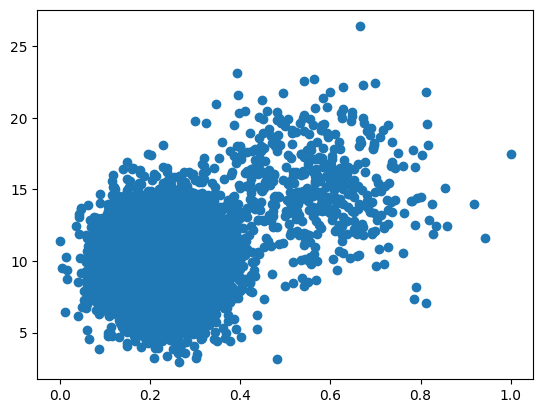

In [136]:
plt.scatter(data["Error_Rate"], original_data["Route_Reply_Frequency"])

In [137]:
data.to_csv("(Dataset 1) SensorNetGuard-processed.csv", index=False)

In [160]:
from sklearn.preprocessing import StandardScaler  # 표준화 패키지 라이브러리 
from sklearn.decomposition import PCA

x = original_data.drop(['Is_Malicious', "Is_Malicious", "IP_Address", "Timestamp", "Node_ID"], axis=1).values # 독립변인들의 value값만 추출
y = original_data['Is_Malicious'].values # 종속변인 추출

x = StandardScaler().fit_transform(x) # x객체에 x를 표준화한 데이터를 저장




In [161]:
for i in range(2, original_data.drop(['Is_Malicious', "Is_Malicious", "IP_Address", "Timestamp", "Node_ID"], axis=1).columns.__len__()+1):
    pca = PCA(n_components=i) # 주성분을 몇개로 할지 결정
    printcipalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data=printcipalComponents)
    # 주성분으로 이루어진 데이터 프레임 구성
    print(f"{i=}")
    print((pca.explained_variance_ratio_))
    print(f"added: {pca.explained_variance_ratio_[-1]}")
    print(np.sum(pca.explained_variance_ratio_))
    print()

i=2
[0.24731927 0.05941638]
added: 0.05941637833963097
0.30673564426551964

i=3
[0.24731928 0.05906124 0.05873938]
added: 0.05873938176571546
0.365119900975824

i=4
[0.24731927 0.05922769 0.0585869  0.05546474]
added: 0.0554647430176334
0.42059860861731585

i=5
[0.24731928 0.05968411 0.05876952 0.05551342 0.05111653]
added: 0.05111652534710932
0.47240285410844685

i=6
[0.24731928 0.0597199  0.05873813 0.05558329 0.05098206 0.04990267]
added: 0.049902672716922586
0.5222453243222018

i=7
[0.24731929 0.05971999 0.05877194 0.05558789 0.0512034  0.05000607
 0.04918758]
added: 0.04918758232950147
0.5717961519593037

i=8
[0.24731929 0.05971999 0.05877194 0.05558789 0.0512034  0.05000607
 0.04918758 0.0487574 ]
added: 0.04875740020793641
0.6205535521672407

i=9
[0.24731929 0.05971999 0.05877194 0.05558789 0.0512034  0.05000607
 0.04918758 0.0487574  0.04811042]
added: 0.04811041850432445
0.6686639706715644

i=10
[0.24731929 0.05971999 0.05877194 0.05558789 0.0512034  0.05000607
 0.04918758 0.0